# Dependencies

The following code installs dependencies and imports modules that are used.


In [5]:
%%bash

# Dependencies
pip install docx2txt
pip install gensim
pip install keras
pip install nltk
pip install -U scikit-learn
pip install python-docx
pip install tensorflow
pip install pandas
pip install openpyxl
pip install nltk
pip install spacy

# python3 -m spacy download en_core_web_sm
python3 -m spacy download en_core_web_trf


172.23.160.1  host
172.23.160.1 	winhost


your 131072x1 screen size is bogus. expect trouble
your 131072x1 screen size is bogus. expect trouble


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [24]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.test.utils import common_texts

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pandas as pd
import csv
import math

# import pprint
import re
import json

import spacy

# Use if en_core_web_sm or en_core_web_trf not installable via python3 in terminal:
# spacy.cli.download("en_core_web_trf")

# Britishise

A utility function which converts words to UK spelling


In [25]:
# Initialises dictionary containing American to UK spelling translations
american_to_british_dict = {}
american_to_british_path = "American-British-English-Translator.json"
with open(american_to_british_path, "r") as file:
    data = file.read()
american_to_british_dict = json.loads(data)


def britishise(sentence):
    """
    Convert words in a sentence to UK spelling to ensure consistency

    Input:
        sentence: An array of strings

    Output:
        sentence: An array of strings, which have been converted to UK spelling
    """

    for j in range(len(sentence)):
        try:
            sentence[j] = american_to_british_dict[sentence[j].lower()]
        except:
            pass

    return sentence

# Verb Classifier

Start by generating a spreadsheet containing verbs to be classified. Use a separate file for each taxonomy.

The spreadsheet should be in the following format: - The first row in each column should contain the header for that column. - Headers must be consistent across sheets within the same file - Subsequent cells in the column should contain a single verb - A separate sheet should be used for each individual source - Sheets should be arranged in order of priority from left to right.

The use the verb_classifier() function to process the spreadsheet and load the verbs into memory.
The output from verb_classifier() should then be stored in a dictionary where the key is the name of the taxonomy.
E.g.
mapped_verbs = {
"Cognitive": verb_classifier(bloom_cognitive_file_path),
"Affective": verb_classifier(bloom_affective_file_path),
"Psychomotor": verb_classifier(bloom_psychomotor_file_path),
"SOLO": verb_classifier(solo_file_path)
}

Next the check_duplicates() function should be used to check the Dataframes for duplicates.


In [26]:
lemmatizer = WordNetLemmatizer()


def verb_classifier(verbs_file_path):  #
    """
    Takes an excel spreadsheet containing verbs, classifies the verbs and stores it into a Dataframe.


    Inputs:
        verbs_file_path: A string that contains the path to the excel spreadsheet to be read

    Outputs:
        domain_levels: A DataFrame which contains all the verbs from the spreadsheet classified into their respective levels
    """

    xlsx = pd.ExcelFile(verbs_file_path, engine="openpyxl")

    sheet_names = xlsx.sheet_names  # Get a list of sheet names

    # Create an empty dictionary to store DataFrames for each sheet
    dfs = {}

    for sheet_name in sheet_names:
        df = xlsx.parse(sheet_name)  # For XLSX files

        # Store the DataFrame in the dictionary
        dfs[sheet_name] = df

    domain_levels = pd.concat(dfs)
    duplicate_checklist = []

    # Iterate over all values in the spreadsheet
    for i in range(domain_levels.shape[0]):
        for j in range(domain_levels.shape[1]):
            cell_value = domain_levels.iloc[i, j]
            if not pd.isna(
                cell_value
            ):  # Format verbs (lower case, UK spelling, lemmatised format)
                cell_value_lower = cell_value.lower()
                verb_brit = britishise([cell_value_lower])[0]
                verb = lemmatizer.lemmatize(verb_brit, pos="v")

                if (
                    verb not in duplicate_checklist
                ):  # Check if the verb is already mapped
                    domain_levels.iloc[i, j] = verb
                    duplicate_checklist.append(verb)
                else:
                    domain_levels.iloc[i, j] = float("nan")

    domain_levels = domain_levels.dropna(how="all")
    return domain_levels

In [27]:
# Paths
solo_file_path = "SOLO.xlsx"
bloom_cognitive_file_path = "Bloom_cognitive.xlsx"
bloom_psychomotor_file_path = "Bloom_psychomotor.xlsx"
bloom_affective_file_path = "Bloom_affective.xlsx"

# Verbs
mapped_verbs = {
    "Cognitive": verb_classifier(bloom_cognitive_file_path),
    "Affective": verb_classifier(bloom_affective_file_path),
    "Psychomotor": verb_classifier(bloom_psychomotor_file_path),
    "SOLO": verb_classifier(solo_file_path),
}

In [28]:
def check_duplicates(verbs_df, domain_name):
    """
    Check the dataframe for duplicate verbs

    verbs_df - The dataframe that consists of the classified verbs
    domain_name - string name of the domain. (SOLO, Blooms Cognitive, Blooms Affective or Blooms Psychomotor)
    """

    # Convert DF to list
    list_of_lists = verbs_df.values.tolist()
    merged_list = [item for sublist in list_of_lists for item in sublist]

    # Remove nan
    cleaned_list = list(filter(lambda x: not pd.isna(x), merged_list))

    # Check for duplicate
    if len(cleaned_list) != len(set(cleaned_list)):
        print("Duplicates Found in " + domain_name)
        print(sorted(cleaned_list))
    else:
        print("No duplicates exist in " + domain_name)

    list_of_lists.clear()
    merged_list.clear()
    cleaned_list.clear()


# Check for duplicates
for taxonomy_key, taxonomy_item in mapped_verbs.items():
    check_duplicates(taxonomy_item, taxonomy_key)
    taxonomy_item.to_csv("./outputs/mapped_verbs_" + taxonomy_key + ".csv")

No duplicates exist in Cognitive
No duplicates exist in Affective
No duplicates exist in Psychomotor
No duplicates exist in SOLO


In [29]:
# Convert mapped_verbs DataFrames which is used to find verbs at a certain level, to a 'dictionary' to lookup the level of a verb
def generate_verb_list(mapped_verbs):
    tp_arr = []
    levels = []
    for t_key, t_item in mapped_verbs.items():
        columns = t_item.columns.values
        for x in range(t_item.shape[0]):
            for y in range(t_item.shape[1]):
                verb = t_item.iloc[x, y]
                if not pd.isna(verb):
                    tp_arr.append((t_key, verb))
                    levels.append(columns[y])

    index = pd.MultiIndex.from_tuples(tp_arr)
    verb_list = pd.DataFrame(levels, index=index, columns=["Level"])
    return verb_list


verb_list = generate_verb_list(mapped_verbs)
print(verb_list)

                                 Level
Cognitive define           Remembering
          classify       Understanding
          choose              Applying
          breakdown          Analysing
          appraise          Evaluating
...                                ...
SOLO      validate   Extended Abstract
          solve        Multistructural
          perform           Relational
          visualise  Extended Abstract
          symbolise    Multistructural

[730 rows x 1 columns]


In [30]:
# Load the English language model in spaCy
# nlp = spacy.load('en_core_web_sm')
nlp = spacy.load("en_core_web_trf", exclude=["ner"])


## Function to identify verbs in a sentence
def identify_verbs(sentence):
    """
    Identify verbs within a sentence and lemmatise them (convert them into their base word)

    Inputs:
        sentence: A string

    Outputs:
        verbs: An array of strings representing identified verbs in their lemmatised form
    """

    # Process the sentence using spaCy
    doc = nlp(sentence)

    # Extract the verbs from the processed sentence
    verbs = [token.lemma_ for token in doc if token.pos_ == "VERB"]

    return verbs

# Extract Columns

A utility function to extract LOs (sentences) and the corresponding levels for each taxonomy the LO is mapped to


In [31]:
def extract_columns(file_path, columns):
    extracted_data = {}

    with open(file_path, "r") as file:
        reader = csv.reader(file)
        headers = next(reader)  # Read the headers

        # Check if all specified columns exist in the CSV file
        for column in columns:
            if column not in headers:
                raise ValueError(f"Column '{column}' not found in the CSV file.")

        # Initialize separate arrays for each column
        for column in columns:
            extracted_data[column] = []

        # Extract data from specified columns
        for row in reader:
            for column in columns:
                column_index = headers.index(column)
                extracted_data[column].append(row[column_index])

    return extracted_data

In [32]:
# Example usage
csv_file = "Learning outcomes manual mapping - Mappings.csv"
# csv_file = 'Learning outcomes manual mapping - Mappings - Testing.csv'
columns_to_extract = ["LO", "Cognitive", "Affective", "Psychomotor", "SOLO"]

extracted_data = extract_columns(csv_file, columns_to_extract)

sentences = extracted_data["LO"]
final_levels = {
    "Cognitive": extracted_data["Cognitive"],
    "Affective": extracted_data["Affective"],
    "Psychomotor": extracted_data["Psychomotor"],
    "SOLO": extracted_data["SOLO"],
}

# Model

The following two code cells contain methods for generating word vectors. The first method involves processing sentences and training a Word2Vec model. The second uses pre-trained word vectors. We found that because the pre-trained word vectors aren't embedded with the context of the learning outcomes it wasn't as accurate.


## Method 1: Word2Vec Model


In [33]:
## Main piece of code that performs the mapping - Approach 2 - 12% accuracy

# wiki word vectors no uppercase
# TODO: Modify this section of the code to use the bloom level verbs from Arragon's spreadsheet, will also need to modify
# Ideas for improving accuracy
#### Reduce the number of verbs.
#### Take more learning outcomes from the monash handbook website(need big dataset for this part) and identify verbs that are appearing multiple times
#### The nummber of times that it appears could be set to a certain number ex: 5.
#### If the verb doesnt appear atleast 5 times, we could remove the verb from our list of predefined verbs which will result in a shorter verb list

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))

# Array of all the PLOs and ULOs (We can couple them together as we're trying to identify Bloom/Solo level here)
lo_sentence_array = []

# TODO: train CLO classification with all data instead of just one course.
for sentence in sentences:
    sentence = re.sub(r"[^\w\s]", "", sentence)
    # Process the sentence using spaCy
    doc = nlp(sentence)

    # Extract the verbs from the processed sentence
    cleaned_tokens = [token.lemma_ for token in doc if token.lower_ not in stop_words]
    cleaned_tokens = britishise(cleaned_tokens)
    lo_sentence_array.append(cleaned_tokens)

# build the vocabulary and train the model
# IMPORTANT, N0TE THAT sg=1 flag specifies Word2Vec to use the Skip Gram Model as designated by the LSTM paper.
model = Word2Vec(
    sentences=lo_sentence_array,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1,
    epochs=30,
)

model.build_vocab(corpus_iterable=verb_list, update=True)
model.update_weights()

model_1_wv = model.wv
# train the model with the course's ULOs and PLOs.
# model.train([tokens], total_examples=len([tokens]), epochs=10)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\musth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\musth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\musth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Method 2: Pre-trained Word Vectors

As this method was only used for accuracy comparison, it has been commented out to save computation time.


In [34]:
# # Download the vector file from https://fasttext.cc/docs/en/english-vectors.html (first file on the website), unzip the file and store in your local development folder

# # Path to the downloaded .vec file
# path_to_vectors = './wiki-news-300d-1M.vec'
# path_to_vectors = 'wiki.en.vec'

# # Load the word vectors
# model_2_wv = KeyedVectors.load_word2vec_format(path_to_vectors)

# # Accuracy when using the KeyedVectors
# # Cognitive:  48 %            Affective:  32 %
# # Psychomotor:  62 %          SOLO:  64 %
# # Total Accuracy:  51 %

# # Find similar words
# similar_words = model_2_wv.most_similar('cat')

# # Calculate word similarity
# similarity = model_2_wv.similarity('cat', 'dog')

# # Perform vector arithmetic
# result = model_2_wv['king'] - model_2_wv['man'] + model_2_wv['woman']

# LO Mapping


In [35]:
def calculate_accuracy(passed_mappings,failed_mappings):

    # Calculate Accuracy
    total_passed = 0
    total_failed = 0
    for taxonomy, passed in passed_mappings.items():
        total_passed += passed
        total_failed += failed_mappings[taxonomy]
        tot = (
            passed + failed_mappings[taxonomy]
            if passed + failed_mappings[taxonomy] > 0
            else 1
        )
        mapping_percentage = math.ceil((passed / (tot)) * 100)
        print("Percentage of ", taxonomy, " mappings passed: ", mapping_percentage, "%")

    total_mapping_percentage = math.ceil(
        (total_passed / (total_passed + total_failed)) * 100
    )
    print("Total percentage of mappings passed: ", total_mapping_percentage, "%")

In [36]:
def output_failed_cases(failed_cases):
# Export Failed Cases
    # print(failed_cases)
    with pd.ExcelWriter("./outputs/failed_lo_mappings.xlsx") as writer:
        failed_cases.to_excel(
            writer,
            sheet_name="Mappings",
            columns=[
                "Sentence",
                "Domain",
                "Manual Level",
                "Auto Level",
                "Verbs Identified",
                "Suggested Verbs",
            ],
        )

In [37]:
def learning_outcome_mapping(
    sentences, final_levels, SIM_THRESHOLD, SUGGESTED_SIM_THRESHOLD
):
    """
    Input:
        sentences: An array of Learning Outcomes (sentences) in string format.
        final levels: An dictionary of arrays. The dictionary keys are the taxonomies and the arrays contain strings representing the final mapped level of the corresponding learning outcome. If LO is not mapped to that domain leave null value
    """
    passed_mappings = {"Cognitive": 0, "Affective": 0, "Psychomotor": 0, "SOLO": 0}
    failed_mappings = {"Cognitive": 0, "Affective": 0, "Psychomotor": 0, "SOLO": 0}

    failed_cases = pd.DataFrame(
        columns=[
            "Sentence",
            "Domain",
            "Manual Level",
            "Auto Level",
            "Verbs Identified",
            "Suggested Verbs",
        ]
    )

    for i in range(len(sentences)):  # Iterates over the LOs
        sentences[i] = britishise(sentences[i])

        # if final_levels[t_key][i] is None or not final_levels[t_key][i] or final_levels[t_key][i] == '-': continue

        identified_verbs = identify_verbs(sentences[i])
        similar_verbs = {}

        score_list = {
            "Cognitive": {
                "Remembering": 0,
                "Understanding": 0,
                "Applying": 0,
                "Analysing": 0,
                "Evaluating": 0,
                "Creating": 0,
            },
            "Affective": {
                "Receiving": 0,
                "Responding": 0,
                "Valuing": 0,
                "Organisation": 0,
                "Characterisation": 0,
            },
            "Psychomotor": {
                "Perception": 0,
                "Set": 0,
                "Guided Response": 0,
                "Mechanism": 0,
                "Complex Overt Response": 0,
                "Adaptation": 0,
                "Origination": 0,
            },
            "SOLO": {
                "Prestructural": 0,
                "Unistructural": 0,
                "Multistructural": 0,
                "Relational": 0,
                "Extended Abstract": 0,
            },
        }

        for taxonomy_key, taxonomy_item in mapped_verbs.items():
            similar_verbs[taxonomy_key] = pd.DataFrame(columns=["Level", "Similarity"])

            for identified_verb in identified_verbs:
                for k in range(taxonomy_item.shape[1]):  # Col (Level)
                    for j in range(taxonomy_item.shape[0]):  # Row
                        verb = taxonomy_item.iloc[j, k]

                        if verb is None or not verb or pd.isna(verb):
                            continue

                        similarity_score = 0
                        try:  # Currently some of the 'verbs' identified are phrases rather than words and it was throwing errors so this is a temp solution
                            sim_score = word_vectors.similarity(identified_verb, verb)
                            if (
                                sim_score >= SUGGESTED_SIM_THRESHOLD
                                and identified_verb != verb
                            ):
                                similar_verbs[taxonomy_key].at[
                                    verb, "Level"
                                ] = taxonomy_item.columns[k]
                                similar_verbs[taxonomy_key].at[
                                    verb, "Similarity"
                                ] = sim_score
                            if sim_score >= SIM_THRESHOLD:
                                similarity_score += sim_score
                        except:
                            pass
                        score_list[taxonomy_key][
                            taxonomy_item.columns[k]
                        ] += similarity_score

        # Identify level based on similarity
        max_score = {
            "Cognitive": {"Level": None, "Score": 0},
            "Affective": {"Level": None, "Score": 0},
            "Psychomotor": {"Level": None, "Score": 0},
            "SOLO": {"Level": None, "Score": 0},
        }
        for t_key, t_item in score_list.items():
            for l in t_item:
                if max_score[t_key]["Score"] < score_list[t_key][l]:
                    max_score[t_key] = {"Level": l, "Score": score_list[t_key][l]}

        # Determine if case passed or failed
        for t_key, t_item in final_levels.items():
            if (
                final_levels[t_key][i] is None
                or not final_levels[t_key][i]
                or final_levels[t_key][i] == "-"
            ):
                continue

            if (
                max_score[t_key]["Level"] != None
                and final_levels[t_key][i].lower() == max_score[t_key]["Level"].lower()
            ):
                passed_mappings[t_key] += 1
            else:
                failed_mappings[t_key] += 1

                x = failed_cases.shape[0]

                failed_cases.at[x, "Sentence"] = sentences[i]
                failed_cases.at[x, "Domain"] = t_key
                failed_cases.at[x, "Manual Level"] = final_levels[t_key][i]
                failed_cases.at[x, "Auto Level"] = max_score[t_key]["Level"]

                # Generate verb and level tuples for sentence data
                s_d_identified_verbs = []
                for verb in identified_verbs:
                    level = "Verb not mapped"
                    try:
                        level = verb_list.at[(t_key, verb), "Level"]
                    except:
                        pass
                    finally:
                        s_d_identified_verbs.append((verb, level))

                failed_cases.at[x, "Verbs Identified"] = s_d_identified_verbs

                # Generate suggested verbs
                sim_verbs = (
                    similar_verbs[t_key]
                    .sort_values(by=["Similarity"], ascending=False)
                    .head(5)
                )
                suggested_verbs = []
                if sim_verbs.shape[0] > 0:
                    suggested_verbs = [
                        (verb, sim_verbs.at[verb, "Level"]) for verb in sim_verbs.index
                    ]
                failed_cases.at[x, "Suggested Verbs"] = suggested_verbs

    output_failed_cases(failed_cases)
    calculate_accuracy(passed_mappings, failed_mappings)

In [38]:
# Testing different similarity thresholds to determine accuracy

# As the main mapping code compares verbs identified in an LO to a complete list of verbs
# and uses their similarity to determine the overall level of the LO, it was theorised
# that verbs which have low similarity could impact the overall accuracy.

# Threshold should be between 0 and 1, i.e. 0% and 100% similarity

# sim_thresholds_arr = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# # Similarity thresholds from 0 to 0.9 all have the same accuracy, thus for following
# # iterations they have been excluded to reduce run time.
# # Cognitive:  27 %            Affective:  23 %
# # Psychomotor:  43 %          SOLO:  52 %
# # Total Accuracy:  36 %
# # Similarity threshold 1 improves the accuracy to:
# # Cognitive:  38 %            Affective:  29 %
# # Psychomotor:  59 %          SOLO:  54 %
# # Total Accuracy:  44 %


# sim_thresholds_arr = [0.9, 0.92, 0.94, 0.96, 0.98, 1]
# # Similarity threshold 0.98 sees a slight decrease in accuracy:
# # Cognitive:  27 %            Affective:  22 %
# # Psychomotor:  43 %          SOLO:  52 %
# # Total Accuracy:  36 %


# sim_thresholds_arr = [0.98, 0.985, 0.99, 0.995, 1]
# # Similarity threshold 0.99 sees a slight increase in accuracy:
# # Cognitive:  29 %            Affective:  22 %
# # Psychomotor:  44 %          SOLO:  52 %
# # Total Accuracy:  36 %
# # Similarity threshold 0.995 sees a major increase in accuracy for most domains,
# # but a decrease for Psychomotor:
# # Cognitive:  43 %            Affective:  38 %
# # Psychomotor:  37 %          SOLO:  52 %
# # Total Accuracy:  43 %

# sim_thresholds_arr = [0.995, 0.996, 0.997, 0.998, 0.999, 1]
# # Similarity threshold 0.996 sees a major increase for Pychomotor in accuracy:
# # Cognitive:  42 %            Affective:  38 %
# # Psychomotor:  61 %          SOLO:  58 %
# # Total Accuracy:  49 %

# # Similarity thresholds 0.96, 0.997, 0.998, 0.999 only vary in accuracy by 1%
# # in different domains. As such 0.997 was chosen as the similarity threshold.

# suggested_sim_threshold = 0.985
# # The suggested similarity threshold is used for generating suggested verbs.
# # This threshold is set lower than the similarity threshold by ~ 0.01 to
# # ensure that enough similar verbs can be found.

# for sim_thresh in sim_thresholds_arr:
#     print("Similarity Threshold: ", sim_thresh)
#     learning_outcome_mapping(sentences, final_levels, sim_thresh, suggested_sim_threshold)
#     print("\n")

In [39]:
# Thresholds to filter the similarity of words to improve accuracy
suggested_sim_threshold = 0.985
sim_threshold = 0.997

# Verbs
mapped_verbs = {
    "Cognitive": verb_classifier(bloom_cognitive_file_path),
    "Affective": verb_classifier(bloom_affective_file_path),
    "Psychomotor": verb_classifier(bloom_psychomotor_file_path),
    "SOLO": verb_classifier(solo_file_path),
}

verb_list = generate_verb_list(mapped_verbs)


print("Method 1")
word_vectors = model_1_wv
learning_outcome_mapping(
    sentences, final_levels, sim_threshold, suggested_sim_threshold
)

# print("\nMethod 2")
# word_vectors = model_2_wv
# learning_outcome_mapping(sentences, final_levels, sim_threshold, suggested_sim_threshold)

Method 1
Percentage of  Cognitive  mappings passed:  43 %
Percentage of  Affective  mappings passed:  29 %
Percentage of  Psychomotor  mappings passed:  59 %
Percentage of  SOLO  mappings passed:  60 %
Total percentage of mappings passed:  47 %


In [40]:
def get_keys_by_value(dictionary, target_value):
    key_value = ""
    for key, value in dictionary.items():
        if value == target_value:
            key_value = key

    if key_value == "":
        key_value = list(dictionary.keys())[-1]
    return key_value

In [41]:
solo = mapped_verbs["SOLO"]

## Rankings are manually derived using the followinng sources
## https://davenport.libguides.com/learningoutcomes/domains#:~:text=Bloom%20identified%20three%20domains%2C%20or,Psychomotor%20Skills%20or%20Physical%20Skills
## https://www.vectorsolutions.com/resources/blogs/teaching-skills-the-psychomotor-domain-of-learning-and-learning-objectives/

# Predefined domain rankings
solo_levels_ranks = {
    "Prestructural": 0,
    "Unistructural": 1,
    "Multistructural": 2,
    "Relational": 3,
    "Extended Abstract": 4,
}

bloom_cognitive_levels_ranks = {
    "Remembering": 0,
    "Understanding": 0,
    "Applying": 1,
    "Analysing": 2,
    "Evaluating": 3,
    "Creating": 4,
}

bloom_affective_levels_ranks = {
    "Receiving": 0,
    "Responding": 1,
    "Valuing": 2,
    "Organisation": 3,
    "Characterisation": 4,
}

bloom_psychomotor_levels_ranks = {
    "Perception": 0,
    "Set": 0,
    "Guided Response": 1,
    "Mechanism": 2,
    "Complex Overt Response": 3,
    "Adaptation": 3,
    "Origination": 4,
}

global solo_copy
solo_copy = solo.copy(deep=True)
solo_copy.reset_index(drop=True, inplace=True)

global bloom_cognitive_copy
bloom_cognitive = mapped_verbs["Cognitive"]
bloom_cognitive_copy = bloom_cognitive.copy(deep=True)
bloom_cognitive_copy.reset_index(drop=True, inplace=True)

global bloom_affective_copy
bloom_affective = mapped_verbs["Affective"]
bloom_affective_copy = bloom_affective.copy(deep=True)
bloom_affective_copy.reset_index(drop=True, inplace=True)

global bloom_psychomotor_copy
bloom_psychomotor = mapped_verbs["Psychomotor"]
bloom_psychomotor_copy = bloom_psychomotor.copy(deep=True)
bloom_psychomotor_copy.reset_index(drop=True, inplace=True)

# bloom_cognitive_copy = bloom_cognitive.copy()

In [42]:
# Identify new verb rankings
def verb_ranking_identifier(
    current_taxonomy,  # Current taxonomy being compared
    comparison_taxonomy,  # Taxonomy being compared with
    verb,  # Curret Verb
    current_taxonomy_ranking_table,  # Ranking table for current taxonomy
    comparison_taxonomy_ranking_table,  # Ranking table for comparison taxonomy
):
    if verb in comparison_taxonomy.values:
        current_taxonomy_level = (
            current_taxonomy[current_taxonomy == verb].stack().index[0][1]
        )
        comparison_taxonomy_level = (
            comparison_taxonomy[comparison_taxonomy == verb].stack().index[0][1]
        )

        current_taxonomy_rank = current_taxonomy_ranking_table[current_taxonomy_level]
        comparison_taxonomy_rank = comparison_taxonomy_ranking_table[
            comparison_taxonomy_level
        ]

        ranking_range = current_taxonomy_rank - comparison_taxonomy_rank

        # Check ranking range of the same verb in the two taxonomies
        if abs(ranking_range) > 1:
            new_current_taxonomy_rank = (
                current_taxonomy_rank + comparison_taxonomy_rank
            ) // 2
            new_current_taxonomy_level = get_keys_by_value(
                current_taxonomy_ranking_table, new_current_taxonomy_rank
            )
            new_comparison_taxonomy_level = get_keys_by_value(
                comparison_taxonomy_ranking_table, new_current_taxonomy_rank
            )
            # Place the verb levels of the current taxonnomy and comparison taxonomy details into the dictionary
            current_taxonomy_dict = {verb: new_current_taxonomy_level}
            comparison_taxonomy_dict = {verb: new_comparison_taxonomy_level}
            current_taxonomy_modifications.append(current_taxonomy_dict)
            comparison_taxonomy_modifications.append(comparison_taxonomy_dict)


def taxonomy_remapping(
    current_taxonomy,
    comparison_taxonomy1,
    comparison_taxonomy2,
    comparison_taxonomy3,
    current_taxonomy_rank,
    comparison_taxonomy1_rank,
    comparison_taxonomy2_rank,
    comparison_taxonomy3_rank,
):
    global current_taxonomy_modifications
    current_taxonomy_modifications = []
    global comparison_taxonomy_modifications
    comparison_taxonomy_modifications = []

    # Check for solo verbs against other taxonomies. Identify new levels to put verbs into
    for i in range(current_taxonomy.shape[0]):  # Level
        for j in range(current_taxonomy.shape[1]):  # Verb
            verb = current_taxonomy.iloc[i, j]

            if verb is None or not verb or pd.isna(verb):
                continue

            verb_ranking_identifier(
                current_taxonomy,
                comparison_taxonomy1,
                verb,
                current_taxonomy_rank,
                comparison_taxonomy1_rank,
            )
            verb_ranking_identifier(
                current_taxonomy,
                comparison_taxonomy2,
                verb,
                current_taxonomy_rank,
                comparison_taxonomy2_rank,
            )

            verb_ranking_identifier(
                current_taxonomy,
                comparison_taxonomy3,
                verb,
                current_taxonomy_rank,
                comparison_taxonomy3_rank,
            )

    # Perform the modifications based on the ranking ranges idetified in the verb ranking identifier
    for i in range(len(current_taxonomy_modifications)):
        current_item = current_taxonomy_modifications[i]
        verb = list(current_item.keys())[0]
        level = list(current_item.values())[0]
        row, col = current_taxonomy[current_taxonomy == verb].stack().index[0]

        if verb == "explain":
            print("fail")
        current_taxonomy.at[row, col] = None
        temp_df = pd.DataFrame({level: verb}, index=[0])
        current_taxonomy = pd.concat([current_taxonomy, temp_df], ignore_index=True)

    for i in range(len(comparison_taxonomy_modifications)):
        current_item = comparison_taxonomy_modifications[i]
        verb = list(current_item.keys())[0]
        level = list(current_item.values())[0]
        temp_df = pd.DataFrame({level: verb}, index=[0])
        if verb == "explain":
            print("fail")

        if level in comparison_taxonomy1.columns:
            row, col = (
                comparison_taxonomy1[comparison_taxonomy1 == verb].stack().index[0]
            )
            comparison_taxonomy1.at[row, col] = None
            comparison_taxonomy1 = pd.concat(
                [comparison_taxonomy1, temp_df], ignore_index=True
            )
        elif level in comparison_taxonomy2.columns:
            row, col = (
                comparison_taxonomy2[comparison_taxonomy2 == verb].stack().index[0]
            )
            comparison_taxonomy2.at[row, col] = None
            comparison_taxonomy2 = pd.concat(
                [comparison_taxonomy2, temp_df], ignore_index=True
            )
        elif level in comparison_taxonomy3.columns:
            row, col = (
                comparison_taxonomy3[comparison_taxonomy3 == verb].stack().index[0]
            )
            comparison_taxonomy3.at[row, col] = None
            comparison_taxonomy3 = pd.concat(
                [comparison_taxonomy3, temp_df], ignore_index=True
            )
        else:
            print(level)
            print("level doesnt exist")

    return (
        current_taxonomy,
        comparison_taxonomy1,
        comparison_taxonomy2,
        comparison_taxonomy3,
    )


# Bloom remapping
taxonomies = taxonomy_remapping(
    bloom_cognitive_copy,
    bloom_affective_copy,
    bloom_psychomotor_copy,
    solo_copy,
    bloom_cognitive_levels_ranks,
    bloom_affective_levels_ranks,
    bloom_psychomotor_levels_ranks,
    solo_levels_ranks,
)
bloom_cognitive_copy = taxonomies[0]
bloom_affective_copy = taxonomies[1]
bloom_psychomotor_copy = taxonomies[2]
solo_copy = taxonomies[3]

# Affective domain mapping
taxonomies = taxonomy_remapping(
    bloom_affective_copy,
    bloom_cognitive_copy,
    bloom_psychomotor_copy,
    solo_copy,
    bloom_affective_levels_ranks,
    bloom_cognitive_levels_ranks,
    bloom_psychomotor_levels_ranks,
    solo_levels_ranks,
)
bloom_affective_copy = taxonomies[0]
bloom_cognitive_copy = taxonomies[1]
bloom_psychomotor_copy = taxonomies[2]
solo_copy = taxonomies[3]

# Psychomotor domain remapping
taxonomies = taxonomy_remapping(
    bloom_psychomotor_copy,
    bloom_affective_copy,
    bloom_cognitive_copy,
    solo_copy,
    bloom_psychomotor_levels_ranks,
    bloom_affective_levels_ranks,
    bloom_cognitive_levels_ranks,
    solo_levels_ranks,
)
bloom_psychomotor_copy = taxonomies[0]
bloom_affective_copy = taxonomies[1]
bloom_cognitive_copy = taxonomies[2]
solo_copy = taxonomies[3]

fail
fail
fail
fail


In [43]:
# A tester funnction for checking verb ranking differences after performing the mapping
def check_verb_rankings(
    current_taxonomy,
    comparison_taxonomy,
    verb,
    current_taxonomy_ranking_table,
    comparison_taxonomy_ranking_table,
):
    if verb in comparison_taxonomy.values:
        current_taxonomy_level = (
            current_taxonomy[current_taxonomy == verb].stack().index[0][1]
        )
        comparison_taxonomy_level = (
            comparison_taxonomy[comparison_taxonomy == verb].stack().index[0][1]
        )

        current_taxonomy_rank = current_taxonomy_ranking_table[current_taxonomy_level]
        comparison_taxonomy_rank = comparison_taxonomy_ranking_table[
            comparison_taxonomy_level
        ]

        ranking_range = current_taxonomy_rank - comparison_taxonomy_rank

        if abs(ranking_range) > 1:
            print(
                verb
                + "-"
                + current_taxonomy_level
                + "-"
                + str(current_taxonomy_rank)
                + "-"
                + str(comparison_taxonomy_rank)
                + "-"
                + comparison_taxonomy_level
            )


def taxonomy_rank_tester(
    current_taxonomy,
    comparison_taxonomy1,
    comparison_taxonomy2,
    comparison_taxonomy3,
    current_taxonomy_rank,
    comparison_taxonomy1_rank,
    comparison_taxonomy2_rank,
    comparison_taxonomy3_rank,
):
    for i in range(current_taxonomy.shape[0]):  # Level
        for j in range(current_taxonomy.shape[1]):  # Verb
            verb = current_taxonomy.iloc[i, j]

            if verb is None or not verb or pd.isna(verb):
                continue

            check_verb_rankings(
                current_taxonomy,
                comparison_taxonomy1,
                verb,
                current_taxonomy_rank,
                comparison_taxonomy1_rank,
            )
            check_verb_rankings(
                current_taxonomy,
                comparison_taxonomy2,
                verb,
                current_taxonomy_rank,
                comparison_taxonomy2_rank,
            )

            check_verb_rankings(
                current_taxonomy,
                comparison_taxonomy3,
                verb,
                current_taxonomy_rank,
                comparison_taxonomy3_rank,
            )


# Test Bloom cognitive against other domains
taxonomy_rank_tester(
    bloom_cognitive_copy,
    bloom_affective_copy,
    bloom_psychomotor_copy,
    solo_copy,
    bloom_cognitive_levels_ranks,
    bloom_affective_levels_ranks,
    bloom_psychomotor_levels_ranks,
    solo_levels_ranks,
)

# Test Bloom affective agains other domains
taxonomy_rank_tester(
    bloom_affective_copy,
    bloom_cognitive_copy,
    bloom_psychomotor_copy,
    solo_copy,
    bloom_affective_levels_ranks,
    bloom_cognitive_levels_ranks,
    bloom_psychomotor_levels_ranks,
    solo_levels_ranks,
)

# Test Bloom psychomotor agianst other domains
taxonomy_rank_tester(
    bloom_psychomotor_copy,
    bloom_affective_copy,
    bloom_cognitive_copy,
    solo_copy,
    bloom_psychomotor_levels_ranks,
    bloom_affective_levels_ranks,
    bloom_cognitive_levels_ranks,
    solo_levels_ranks,
)

# bloom_cognitive_copy

In [44]:
suggested_sim_threshold = 0.985
sim_threshold = 0.997

# Before changing rankings
# Percentage of  Cognitive  mappings passed:  31 %
# Percentage of  Affective  mappings passed:  33 %
# Percentage of  Psychomotor  mappings passed:  29 %
# Percentage of  SOLO  mappings passed:  27 %
# Total percentage of mappings passed:  30 %

# After changing rankings
# Percentage of  Cognitive  mappings passed:  29 %
# Percentage of  Affective  mappings passed:  27 %
# Percentage of  Psychomotor  mappings passed:  29 %
# Percentage of  SOLO  mappings passed:  36 %
# Total percentage of mappings passed:  30 %

mapped_verbs = {
    "Cognitive": bloom_cognitive_copy,
    "Affective": bloom_affective_copy,
    "Psychomotor": bloom_psychomotor_copy,
    "SOLO": solo_copy,
}
verb_list = generate_verb_list(mapped_verbs)

print("Method 1: Before adding solo verbs to other domains")

word_vectors = model_1_wv
learning_outcome_mapping(
    sentences, final_levels, sim_threshold, suggested_sim_threshold
)

Method 1: Before adding solo verbs to other domains
Percentage of  Cognitive  mappings passed:  34 %
Percentage of  Affective  mappings passed:  22 %
Percentage of  Psychomotor  mappings passed:  55 %
Percentage of  SOLO  mappings passed:  28 %
Total percentage of mappings passed:  34 %


In [45]:
# mapping solo verbs into other domains

for i in range(solo_copy.shape[0]):  # Level
    for j in range(solo_copy.shape[1]):  # Verb
        verb = solo_copy.iloc[i, j]

        if verb is None or not verb or pd.isna(verb):
            continue

        # Get level and ranking of current verb
        solo_level = solo_copy[solo_copy == verb].stack().index[0][1]
        solo_level_rank = solo_levels_ranks[solo_level]

        # Check if solo verb exists in each domain
        # If verb does not exist in the domain, map the current solo verb into the domain dataframe at the level ranking same as solo level rank
        if verb not in bloom_cognitive_copy.values:
            bloom_cognitive_level = get_keys_by_value(
                bloom_cognitive_levels_ranks, solo_level_rank
            )
            temp_df = pd.DataFrame({bloom_cognitive_level: verb}, index=[0])
            bloom_cognitive_copy = pd.concat(
                [bloom_cognitive_copy, temp_df], ignore_index=True
            )

        if verb not in bloom_affective_copy.values:
            bloom_affective_level = get_keys_by_value(
                bloom_affective_levels_ranks, solo_level_rank
            )
            temp_df = pd.DataFrame({bloom_affective_level: verb}, index=[0])
            bloom_affective_copy = pd.concat(
                [bloom_affective_copy, temp_df], ignore_index=True
            )

        if verb not in bloom_psychomotor_copy.values:
            bloom_psychomotor_level = get_keys_by_value(
                bloom_psychomotor_levels_ranks, solo_level_rank
            )
            temp_df = pd.DataFrame({bloom_psychomotor_level: verb}, index=[0])
            bloom_psychomotor_copy = pd.concat(
                [bloom_psychomotor_copy, temp_df], ignore_index=True
            )

In [46]:
suggested_sim_threshold = 0.985
sim_threshold = 0.997

# Before changing rankings
# Percentage of  Cognitive  mappings passed:  31 %
# Percentage of  Affective  mappings passed:  33 %
# Percentage of  Psychomotor  mappings passed:  29 %
# Percentage of  SOLO  mappings passed:  27 %
# Total percentage of mappings passed:  30 %

# After changing rankings
# Percentage of  Cognitive  mappings passed:  29 %
# Percentage of  Affective  mappings passed:  27 %
# Percentage of  Psychomotor  mappings passed:  29 %
# Percentage of  SOLO  mappings passed:  36 %
# Total percentage of mappings passed:  30 %

mapped_verbs = {
    "Cognitive": bloom_cognitive_copy,
    "Affective": bloom_affective_copy,
    "Psychomotor": bloom_psychomotor_copy,
    "SOLO": solo_copy,
}
verb_list = generate_verb_list(mapped_verbs)

print("Method 1: After adding solo verbs to other domains")

word_vectors = model_1_wv
learning_outcome_mapping(
    sentences, final_levels, sim_threshold, suggested_sim_threshold
)

Method 1: After adding solo verbs to other domains
Percentage of  Cognitive  mappings passed:  34 %
Percentage of  Affective  mappings passed:  23 %
Percentage of  Psychomotor  mappings passed:  47 %
Percentage of  SOLO  mappings passed:  28 %
Total percentage of mappings passed:  32 %


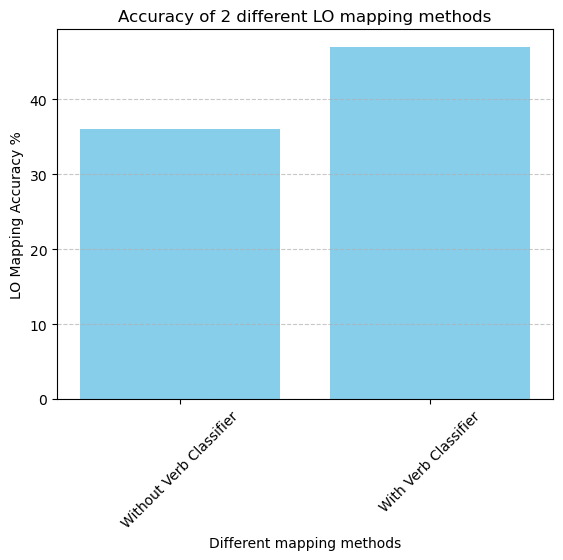

In [50]:
import matplotlib.pyplot as plt

categories = ["Without Verb Classifier", "With Verb Classifier"]
values = [36, 47]

plt.bar(categories, values)

plt.bar(categories, values, color='skyblue')  # Set the bar color
plt.xlabel('Different mapping methods')  # Label for the x-axis
plt.ylabel('LO Mapping Accuracy %')      # Label for the y-axis
plt.title('Comparing accuracy of 2 different LO mapping methods')  # Title of the chart
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a horizontal grid line

plt.show()
